In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math
import scipy
%matplotlib inline

# Two-sided inverse Students t-distribution
# p - probability, df - degrees of freedom
from scipy.stats import t
tinv = lambda p, df: abs(t.ppf(p/2, df))


In [2]:
class QPCR(object):
    def __init__(self, filename: str, header: int, std_wells: list, sample_wells: list, measures_per_cycle: int,
                 cycles: int, std_concentration: float, sample_concentrations: np.ndarray, std_bps: int,
                 sample_bps: int, reaction_volume: float, remove_std_well=None):
        """
        :param filename: data file exported by qPCR instruments
        :param header: number of headers within the exported csv file
        :param std_wells: if bad data point is encountered, remove it from the std_wells list
        :param sample_wells: names of sample wells for PCR
        :param measures_per_cycle: measurement can be performed many times within a cycle,
                                only first and last data points are used for calculating of amplification profile
        :param cycles: maximum number of cycles for computation
        :param std_concentration: concentration of standard sample, unit ng/ul
        :param sample_concentrations: concentration of tested sample, unit ng/ul
        :param std_bps: number of base pairs of the standard sample sequence
        :param sample_bps: number of base pairs of the tested sample sequence
        :param reaction_volume: final volum of the PCR reaction
        """
        self.fontdict = {'family': 'Times New Roman', 'size': 20}
        if ".xls" in filename or ".xlsx" in filename:
            self.raw = pd.read_excel(filename, header=header).set_index("Well")
        elif ".csv" in filename:
            self.raw = pd.read_csv(filename, header=header).set_index("Well")

        # params
        self.t = np.arange(cycles)
        self.std_con = std_con
        c = self.calculate_copy_number(std_bps, self.std_con, reaction_volume)
        self.std_wells = []
        self.std_n0s = []
        if remove_std_well is None:
            remove_std_well = []
        for i, well in enumerate(std_wells):
            if well in remove_std_well:
                continue
            else:
                self.std_wells.append(well)
                self.std_n0s.append(c / 10**i)
        self.std_n0s = np.array(self.std_n0s)
        self.n_std = len(self.std_wells)
        
        self.sample_wells = sample_wells
        self.n_sample = len(sample_wells)
        self.N = self.n_std + self.n_sample
        
        # calculate standard and testing sample copy numbers, asssuming all testing samples have the same bps
        self.sample_cons = sample_concentrations
        self.sample_n0s = np.zeros(self.n_sample)
        for i in range(self.n_sample):
            self.sample_n0s[i] = self.calculate_copy_number(sample_bps, self.sample_cons[i], reaction_volume)

        self.corrected_amp_fold = np.zeros((self.N, cycles - 1))
        self.corrected_amp = np.zeros((self.N, cycles))
        self.std_indexes = []
        self.sample_idxs = []
        self.std_level = 0
        self.caf = np.ones((self.N, cycles))
        self.std_param = np.zeros((2))  # slope, intercept
        self.std_param_classical = np.zeros((2))  # slope, intercept

        # extract fluorescence data and storing amplification profile in a np.ndarray, rows: well, cols: fl
        if measures_per_cycle > 1:
            self.fl = np.zeros((measures_per_cycle, self.N, cycles))
            for i in range(measures_per_cycle):
                for j, well in enumerate(self.std_wells + self.sample_wells):
                    x = self.raw.loc[well, "SYBR"].values.astype(float)
                    self.fl[i, j, :] = x[measures_per_cycle * self.t + i]
            self.amp = self.fl[measures_per_cycle - 1, :, :] - self.fl[0, :, :]  # after_extension - baseline_in_denaturation_status
        else:
            self.fl = np.zeros((self.N, cycles))
            for i, well in enumerate(self.std_wells + self.sample_wells):
                sybr = self.raw.loc[well, "SYBR"].values.astype(float)
                rox = self.raw.loc[well, "ROX"].values.astype(float)
                self.fl[i] = sybr[self.t]
            self.amp = self.fl

        # calculate observed efficiencies for all samples
        self.efficiencies = np.zeros((self.N, cycles - 1))
        self.efficiencies[:, 0] = 0
        for i in range(1, cycles - 1):
            self.efficiencies[:, i] = self.amp[:, i + 1] / self.amp[:, i] - 1
            
        # pre-fitting to normalize the initial fluorescence level, obtaining corrected amp
        for i, well in enumerate(self.std_wells+self.sample_wells):
            idx = np.argmax(self.efficiencies[i])
            try:
                popt, pcov = scipy.optimize.curve_fit(self.exp_func,
                                                      np.arange(idx + 1), self.amp[i, :idx + 1],
                                                      p0=[2, 10, 100, 10000],
                                                      bounds=([0, 0, 0, -np.inf], [3, np.inf, np.inf, np.inf]),
                                                      method='trf')
                self.corrected_amp[i] = self.amp[i] - popt[3]
            except:
                self.corrected_amp[i] = self.amp[i]

        # calculate corrected amplification factors for standard samples
        amp_at_max_efficiency = []
        for i, well in enumerate(self.std_wells):
            idx = np.argmax(self.efficiencies[i])  # fitting to the maximum observed efficiency, corresponds to data point amp[idx+1]
            self.std_indexes.append(idx)
            amp_at_max_efficiency.append(self.corrected_amp[i, idx])
            try:
                popt, pcov = scipy.optimize.curve_fit(self.exp_func,
                                                      np.arange(idx + 1), self.amp[i, :idx + 1],
                                                      p0=[2, 10, 100, 0],
                                                      bounds=([0, 0, 0, -np.inf], [3, np.inf, np.inf, np.inf]),
                                                      method='trf')
                self.corrected_amp_fold[i, :idx] = popt[0]  
                self.corrected_amp_fold[i, idx:] = self.efficiencies[i, idx:] + 1  # concatenate to amp_fold calculated by amp profiles
            except:
                print(f"Efficiency fitting of sample {well} is failed.")
                self.corrected_amp_fold[i, :idx] = 2  # assume maximum efficiency
                self.corrected_amp_fold[i, idx:] = self.efficiencies[i, idx:] + 1  # concatenate to amp_fold calculated by amp profiles

        self.std_level = np.array(amp_at_max_efficiency).mean()

        # calculate corrected amplification factors for testing samples
        for i, well in enumerate(self.sample_wells):
            j = i + self.n_std
            idx = np.argmax(self.corrected_amp[j] - self.std_level > 0)
            self.sample_idxs.append(idx)
            try:
                popt, pcov = scipy.optimize.curve_fit(self.exp_func,
                                                      np.arange(idx + 1), self.amp[j, :idx + 1],
                                                      p0=[2, 10, 100, 0],
                                                      bounds=([0, 0, 0, -np.inf], [3, np.inf, np.inf, np.inf]),
                                                      method='trf')
                self.corrected_amp_fold[j, :idx] = popt[0] 
                self.corrected_amp_fold[j, idx:] = self.efficiencies[j, idx:] + 1  # concatenate to amp_fold calculated by amp profiles
            except:
                print(f"Efficiency fitting of sample {well} is failed.")
                self.corrected_amp_fold[j, :idx] = 2  # assume maximum efficiency
                self.corrected_amp_fold[j, idx:] = self.efficiencies[j, idx:] + 1  # concatenate to amp_fold calculated by amp profiles

        # with amp and caf and we are done
        self.corrected_amp[self.corrected_amp < 1] = 1 # avoid log erroneous
        self.caf[:, 1:] = np.cumprod(self.corrected_amp_fold, axis=1)
        self.log_amp = np.log10(self.corrected_amp)
        self.log_caf = np.log10(self.caf)

    def exp_func(self, n, E, a, b, c):
        "exponential function with linear shift correction"
        return a * E ** n + b * n + c

    def plot_standard_sample_amplification_profile(self):
        plt.figure(figsize=(10, 8))
        for i, well in enumerate(self.std_wells):
            plt.plot(self.t, self.corrected_amp[i], label=well, marker='o')
        plt.legend()
        plt.xlabel("Cycle", fontdict=self.fontdict)
        plt.ylabel("Net Fluorescence Signal (a.u.)", fontdict=self.fontdict)
        # plt.savefig("std_net_fluorescence_signal.tif", dpi=300)
        plt.title("Amplification profiles of standard samples")
        plt.show()

    def plot_standard_sample_efficiency(self):
        plt.figure(figsize=(10, 8))
        for i, well in enumerate(self.std_wells):
            plt.plot(self.t[1:45], self.efficiencies[i], label=well)
        plt.legend()
        plt.xlabel("Cycle", fontdict=self.fontdict)
        plt.ylabel("Observed efficiency", fontdict=self.fontdict)
        # plt.savefig("observed_efficiency.tif", dpi=300)
        plt.title("Efficiency profiles of standard samples")
        plt.show()

    def plot_standard_sample_corrected_efficiencies(self):
        plt.figure(figsize=(10, 8))
        for i, well in enumerate(self.std_wells):
            plt.plot(self.t[1:], self.corrected_amp_fold[i] - 1, label=well)
        plt.legend()
        plt.xlabel("Cycle", fontdict=self.fontdict)
        plt.ylabel("Corrected efficiency", fontdict=self.fontdict)
        # plt.savefig("corrected_efficiency.tif", dpi=300)
        plt.title("Corrected efficiency profiles of standard samples")
        plt.show()

    def plot_standard_sample_amp_caf(self):
        plt.figure(figsize=(10, 8))
        for i, well in enumerate(self.std_wells):
            plt.plot(self.log_caf[i], self.log_amp[i], label=well, marker='o')
        plt.legend()
        plt.xlabel("Cumulative amplification factor", fontdict=self.fontdict)
        plt.ylabel("Net Fluorescence Signal (a.u.)", fontdict=self.fontdict)
        # plt.savefig("caf_amp.tif", dpi=300)
        plt.title("Correlation of amplification factor with fluorescence signal")
        plt.show()

    def intersect(self, x, y, th):
        """
        function for calculating the cross point (cx, cy) of a predefined threshold th with the given curve (x, y)
        """
        cx, cy = 0, 0
        dy = th - y
        for i in range(len(y) - 1):
            if np.dot(dy[i], dy[i + 1]) == 0:
                if dy[i] == 0:
                    cx = x[i]
                    cy = y[i]
                if dy[i + 1] == 0:
                    cx = x[i + 1]
                    cy = y[i + 1]
            elif np.dot(dy[i], dy[i + 1]) < 0:
                cx = x[i] + dy[i] * (x[i + 1] - x[i]) / (y[i + 1] - y[i])
                cy = y[i] + dy[i]
            else:
                pass
        return cx, cy

    def calculate_copy_number(self, length: int, concentration: float, volume: float):
        """
        for yeast cell
        concentration: ng/ul
        volume: ul
        length: number of base pairs
        """
        mass = concentration * volume * 1e-9  # g
        mass_per_molecule = length * 618 / (6.02214199 * 1e23)  # g/molecule
        return mass / mass_per_molecule

    def plot_standard_curve(self):
        plt.figure(figsize=(10, 8))
        y_max = -np.inf
        y_min = np.inf
        for i, well in enumerate(self.std_wells):
            idx = self.std_indexes[i]
            iy = self.log_amp[i, idx:]
            y_max = y_max if y_max > iy.max() else iy.max()
            y_min = y_min if y_min < iy.min() else iy.min()
        ty = np.linspace(y_min, y_max)
        slopes = []
        intercepts = []
        for i, well in enumerate(self.std_wells):
            idx = self.std_indexes[i]
            ix = self.log_caf[i, idx:]
            iy = self.log_amp[i, idx:]
            plt.scatter(ix, iy, label=well, marker='o')
            slope, intercept, rvalue, pvalue, stderr = scipy.stats.linregress(x=ix, y=iy)
            slopes.append(slope)
            intercepts.append(intercept)
            plt.plot((ty - intercept) / slope, ty)

        plt.legend()
        plt.xlabel("Cumulative amplification factor", fontdict=self.fontdict)
        plt.ylabel("Net Fluorescence Signal (a.u.)", fontdict=self.fontdict)
        # plt.savefig("truncated_caf_amp.tif", dpi=300)
        plt.title("Linear fitting of amplification factor with fluorescence signal")
        plt.show()

        plt.figure(figsize=(10, 8))
        intercepts = np.array(intercepts)
        sns.regplot(x=intercepts, y=np.log10(self.std_n0s))

        for i, well in enumerate(self.std_wells):
            plt.scatter(intercepts[i], np.log10(self.std_n0s[i]), label=well)  # plot data point with colors corresponding to previous figures

        res = scipy.stats.linregress(x=intercepts, y=np.log10(self.std_n0s))
        self.std_param[0] = res.slope
        self.std_param[1] = res.intercept
        plt.legend()
        plt.xlabel(r'Intercept', fontdict=self.fontdict)
        plt.ylabel(r'Logarithm of copy number', fontdict=self.fontdict)
        # plt.savefig("standard_curve.tif", dpi=300)
        plt.title("Standard curve")
        plt.show()
        ts = tinv(0.05, len(intercepts) - 2)
        print(f"slope (95% confidence interval): {res.slope:.6f} +/- {ts * res.stderr:.6f}")
        print(f"intercept (95% confidence interval): {res.intercept:.6f} +/- {ts * res.intercept_stderr:.6f}")
        print(f"R-squared: {res.rvalue ** 2:.6f}")
        print(f"statistically significance: {res.pvalue}")

    def plot_classical_standard_curve(self, threshold):
        plt.figure(figsize=(10, 8))
        cps = []
        for i, well in enumerate(self.std_wells):
            ix = self.t
            iy = self.corrected_amp[i]
            cx, cy = self.intersect(ix, iy, threshold)
            cps.append(cx)

        cps = np.array(cps)
        sns.regplot(x=cps, y=np.log10(self.std_n0s))

        for i, well in enumerate(self.std_wells):
            plt.scatter(cps[i], np.log10(self.std_n0s[i]), label=well)
            
        res = scipy.stats.linregress(x=cps, y=np.log10(self.std_n0s))
        self.std_param_classical[0] = res.slope
        self.std_param_classical[1] = res.intercept
        plt.legend()
        plt.xlabel(r'$C_T$', fontdict=self.fontdict)
        plt.ylabel(r'Logarithm of copy number', fontdict=self.fontdict)
        # plt.savefig("classical_standard_curve.tif", dpi=300)
        plt.title("Classical_standard curve")
        plt.show()
        ts = tinv(0.05, len(self.std_wells) - 2)
        print(f"slope (95% confidence interval): {res.slope:.6f} +/- {ts * res.stderr:.6f}")
        print(f"intercept (95% confidence interval): {res.intercept:.6f} +/- {ts * res.intercept_stderr:.6f}")
        print(f"R-squared: {res.rvalue ** 2:.6f}")
        print(f"statistically significance: {res.pvalue}")

    def calculate_CNV(self, exclude=None):
        if exclude is None:
            exclude = []
        slopes = []
        intercepts = []
        plt.figure(figsize=(10, 8))
        for i, well in enumerate(self.sample_wells):
            if well in exclude:
                continue
            else:
                j = i + self.n_std
                idx = self.sample_idxs[i]
                ix = self.log_caf[j, idx:]
                iy = self.log_amp[j, idx:]
                plt.scatter(ix, iy, label=well, marker='o')
                slope, intercept, rvalue, pvalue, stderr = scipy.stats.linregress(x=ix, y=iy)
                slopes.append(slope)
                intercepts.append(intercept)
                plt.plot(ix, slope * ix + intercept)
        plt.legend(bbox_to_anchor=(1.2, 0.5), loc=7, borderaxespad=0)
        plt.xlabel("Cumulative amplification factor", fontdict=self.fontdict)
        plt.ylabel("Net Fluorescence Signal (a.u.)", fontdict=self.fontdict)
        # plt.savefig("truncated_caf_amp_sample.tif", dpi=300)
        plt.title("Linear fitting of amplification factor with fluorescence signal")
        plt.show()

        log_cn = np.array(intercepts) * self.std_param[0] + self.std_param[1]
        cnv = []
        j = 0
        for i, well in enumerate(self.sample_wells):
            if well in exclude:
                continue
            else:
                tmp = 10 ** log_cn[j] / self.sample_n0s[i]
                cnv.append(tmp)
                print(f"# {i}: CNV for well {well} is {tmp}")
                j += 1
        return np.array(cnv)

    def calculate_CNV_classical(self, threshold, exclude=None):
        if exclude is None:
            exclude = []
        cps = []
        for i, well in enumerate(self.sample_wells):
            if well in exclude:
                continue
            else:
                j = i + self.n_std
                ix = self.t
                iy = self.corrected_amp[j]
                cx, cy = self.intersect(ix, iy, threshold)
                cps.append(cx)
                
        log_cn = np.array(cps) * self.std_param_classical[0] + self.std_param_classical[1]
        cnv = []
        j = 0
        for i, well in enumerate(self.sample_wells):
            if well in exclude:
                continue
            else:
                tmp = 10 ** log_cn[j] / self.sample_n0s[i]
                cnv.append(tmp)
                print(f"# {i}: CNV for well {well} is {tmp}")
                j += 1            
        return np.array(cnv)

In [3]:
file = "./data_20221109.xlsx"

std_wells = [i + "1" for i in "ABCDEFGH"]
std_con = np.array([159.8, 158.4, 160.7]).mean() # unit ng/ul

guanidine_1_names = [i + "3" for i in "ABCD"]
guanidine_2_names = [i + "3" for i in "EFGH"]
guanidine_3_names = [i + "4" for i in "ABCD"]
guanidine_4_names = [i + "4" for i in "EFGH"]

urea_1_names = [i + "5" for i in "ABCD"]
urea_2_names = [i + "5" for i in "EFGH"]
urea_3_names = [i + "6" for i in "ABCD"]
urea_4_names = [i + "6" for i in "EFGH"]

sample_wells = guanidine_1_names + guanidine_2_names + guanidine_3_names + guanidine_4_names + urea_1_names + urea_2_names + urea_3_names + urea_4_names
cons = np.array([[14.6, 15.7, 15.9], [25.4, 25.6, 25.7], [19.3, 19.0, 18.3], [17.1, 17.4, 17.2]]).mean(axis=1) # unit ng/ul    
sample_cons = []
for i in range(2):
    for j in range(4):
        for k in range(4):
            sample_cons.append(cons[j])
sample_cons = np.array(sample_cons)
qpcr = QPCR(filename=file, header=7, std_wells=std_wells, sample_wells=sample_wells, 
            measures_per_cycle=3, cycles=40, std_concentration=std_con, sample_concentrations=sample_cons, 
            std_bps=1682, sample_bps=12495682, reaction_volume=2, remove_std_well=[i + "1" for i in "ABC"])

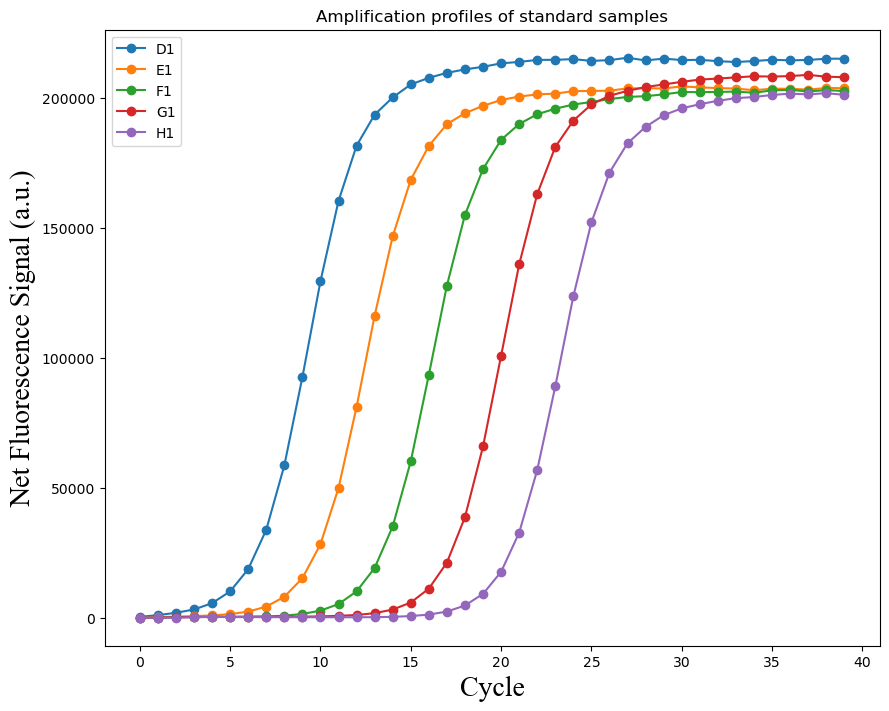

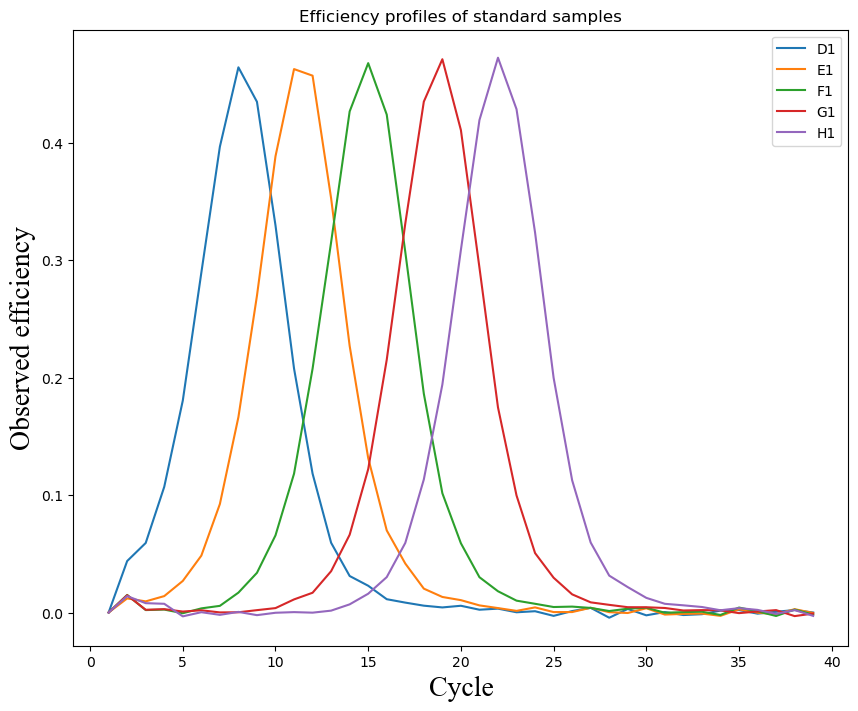

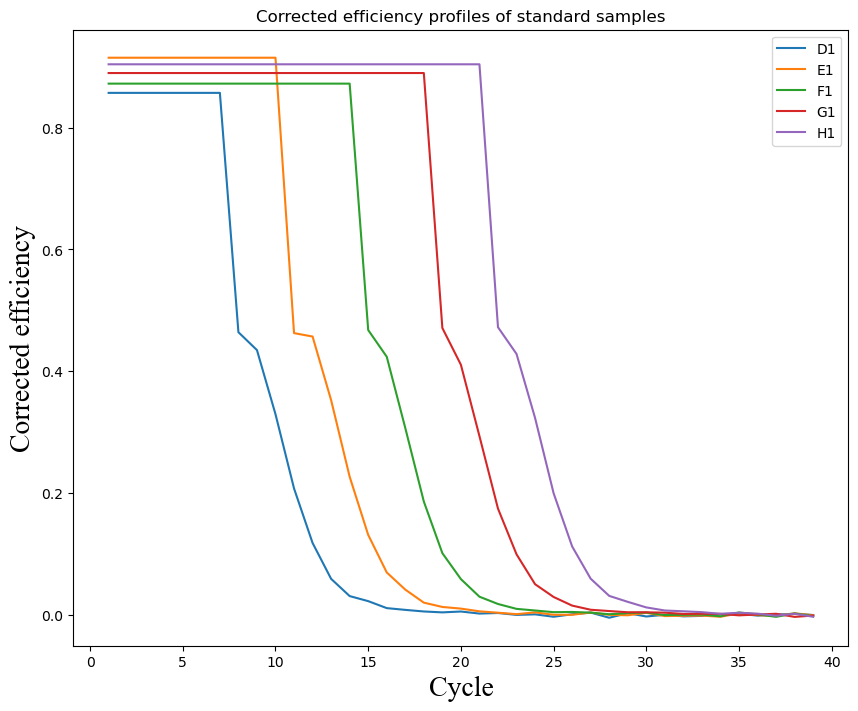

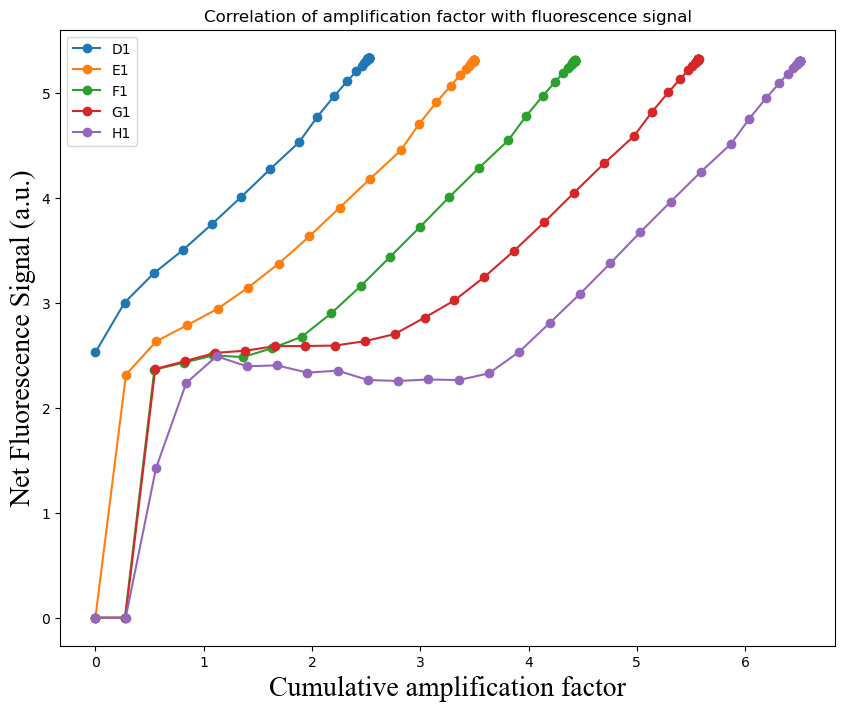

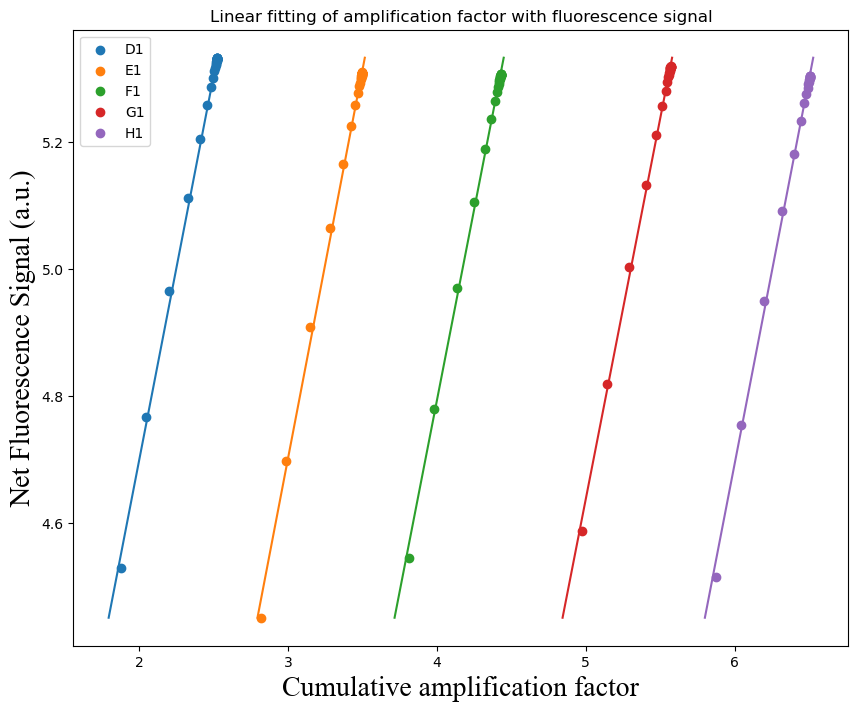

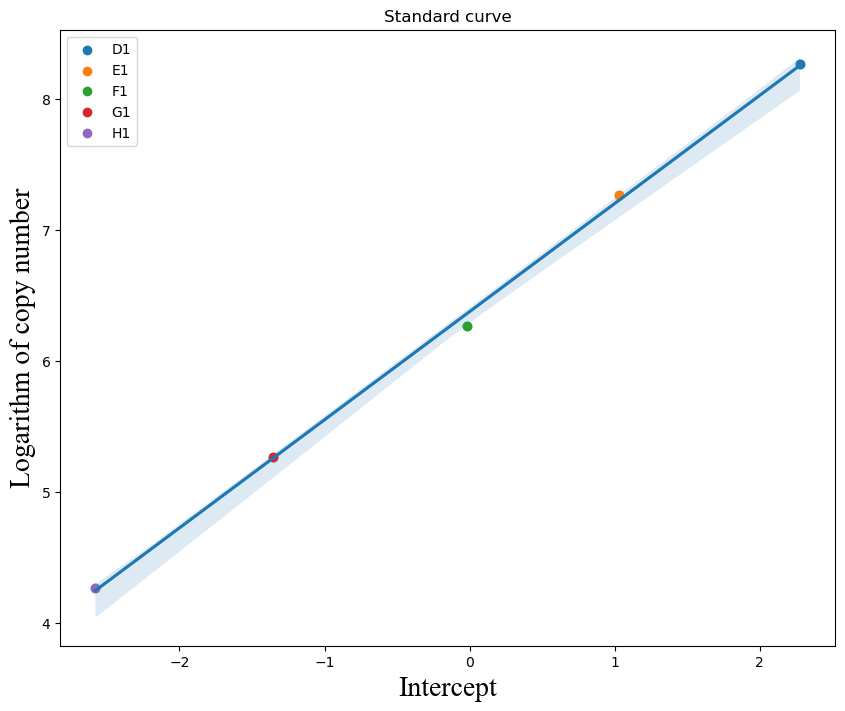

slope (95% confidence interval): 0.825338 +/- 0.049931
intercept (95% confidence interval): 6.374142 +/- 0.085755
R-squared: 0.998917
statistically significance: 1.512986676078316e-05


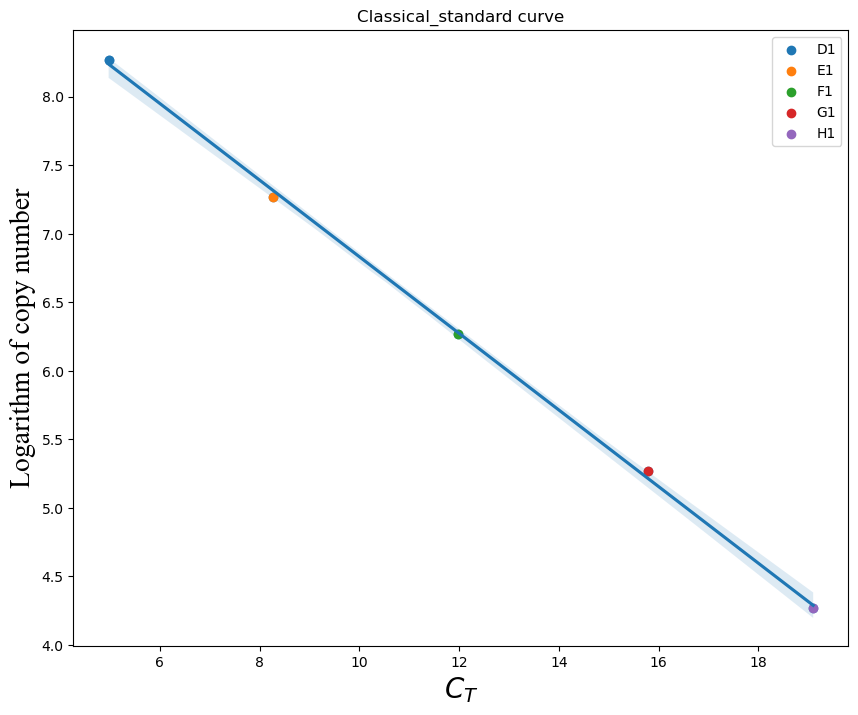

slope (95% confidence interval): -0.279522 +/- 0.012971
intercept (95% confidence interval): 9.626542 +/- 0.169132
R-squared: 0.999363
statistically significance: 6.831420867350523e-06


In [4]:
qpcr.plot_standard_sample_amplification_profile()
qpcr.plot_standard_sample_efficiency()
qpcr.plot_standard_sample_corrected_efficiencies()
qpcr.plot_standard_sample_amp_caf()
qpcr.plot_standard_curve()
qpcr.plot_classical_standard_curve(10000)

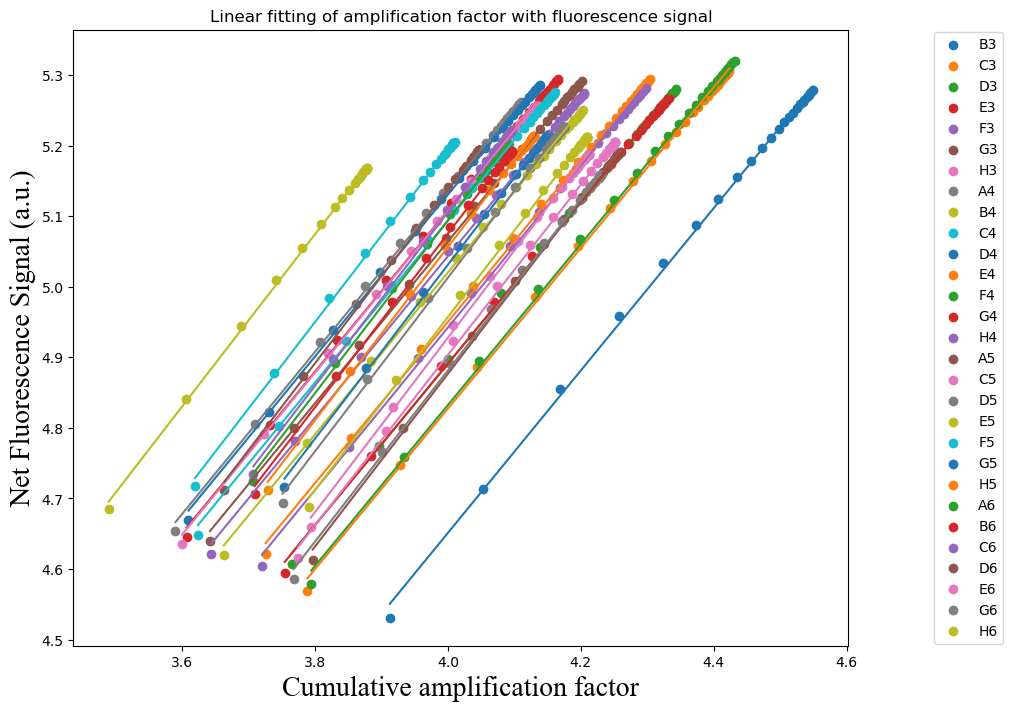

# 1: CNV for well B3 is 1.0832893636353618
# 2: CNV for well C3 is 1.6599402589049568
# 3: CNV for well D3 is 1.6506788228548732
# 4: CNV for well E3 is 1.6404755701396496
# 5: CNV for well F3 is 1.4435901263632087
# 6: CNV for well G3 is 1.479171757351428
# 7: CNV for well H3 is 1.6058398009365944
# 8: CNV for well A4 is 2.2525418453261037
# 9: CNV for well B4 is 1.8323629595880178
# 10: CNV for well C4 is 2.108726766504693
# 11: CNV for well D4 is 2.2540448081045406
# 12: CNV for well E4 is 1.8086338524746903
# 13: CNV for well F4 is 1.6183602455573363
# 14: CNV for well G4 is 1.6073681499930708
# 15: CNV for well H4 is 1.681735516900588
# 16: CNV for well A5 is 0.9492855126438806
# 18: CNV for well C5 is 1.1408815020931564
# 19: CNV for well D5 is 1.0447757024325266
# 20: CNV for well E5 is 1.3649102450859238
# 21: CNV for well F5 is 1.0450667850385826
# 22: CNV for well G5 is 0.7201182263424368
# 23: CNV for well H5 is 0.7836023830836774
# 24: CNV for well A6 is 1.1678433037337224


In [5]:
ncnv1 = qpcr.calculate_CNV(exclude=["F6", "A3", "B5"])

In [6]:
ccnv1 = qpcr.calculate_CNV_classical(10000, exclude=["F6", "A3", "B5"])

# 1: CNV for well B3 is 0.25035686388248657
# 2: CNV for well C3 is 0.2900917116376829
# 3: CNV for well D3 is 0.2974100068643564
# 4: CNV for well E3 is 0.2223550699132811
# 5: CNV for well F3 is 0.2088952665413151
# 6: CNV for well G3 is 0.21801710669017077
# 7: CNV for well H3 is 0.2180202097900539
# 8: CNV for well A4 is 0.3083362097189093
# 9: CNV for well B4 is 0.2800949969916822
# 10: CNV for well C4 is 0.3022538028120107
# 11: CNV for well D4 is 0.31488196120638784
# 12: CNV for well E4 is 0.30060533206373136
# 13: CNV for well F4 is 0.2882791810880869
# 14: CNV for well G4 is 0.2816306523285507
# 15: CNV for well H4 is 0.28985607388450546
# 16: CNV for well A5 is 0.5606216964829223
# 18: CNV for well C5 is 0.6288285493939739
# 19: CNV for well D5 is 0.5787795702812991
# 20: CNV for well E5 is 0.43700278276555676
# 21: CNV for well F5 is 0.44153202118128065
# 22: CNV for well G5 is 0.41965793866325274
# 23: CNV for well H5 is 0.4200988242005547
# 24: CNV for well A6 is 0.587120

In [7]:
file = "./data_20221110.xlsx"

std_wells = [i + "1" for i in "ABCDEFGH"]
std_con = np.array([159.8, 158.4, 160.7]).mean() # unit ng/ul

guanidine_1_names = [i + "3" for i in "ABCD"]
guanidine_2_names = [i + "3" for i in "EFGH"]
guanidine_3_names = [i + "4" for i in "ABCD"]
guanidine_4_names = [i + "4" for i in "EFGH"]

urea_1_names = [i + "5" for i in "ABCD"]
urea_2_names = [i + "5" for i in "EFGH"]
urea_3_names = [i + "6" for i in "ABCD"]
urea_4_names = [i + "6" for i in "EFGH"]

sample_wells = guanidine_1_names + guanidine_2_names + guanidine_3_names + guanidine_4_names + urea_1_names + urea_2_names + urea_3_names + urea_4_names
cons = np.array([[14.6, 15.7, 15.9], [25.4, 25.6, 25.7], [19.3, 19.0, 18.3], [17.1, 17.4, 17.2]]).mean(axis=1) # unit ng/ul    
sample_cons = []
for i in range(2):
    for j in range(4):
        for k in range(4):
            sample_cons.append(cons[j])
sample_cons = np.array(sample_cons)
qpcr = QPCR(filename=file, header=7, std_wells=std_wells, sample_wells=sample_wells, 
            measures_per_cycle=1, cycles=40, std_concentration=std_con, sample_concentrations=sample_cons, 
            std_bps=1682, sample_bps=12495682, reaction_volume=2, remove_std_well=[i + "1" for i in "ABC"])

D:\anaconda\envs\data\lib\site-packages\scipy\optimize\_minpack_py.py:881: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


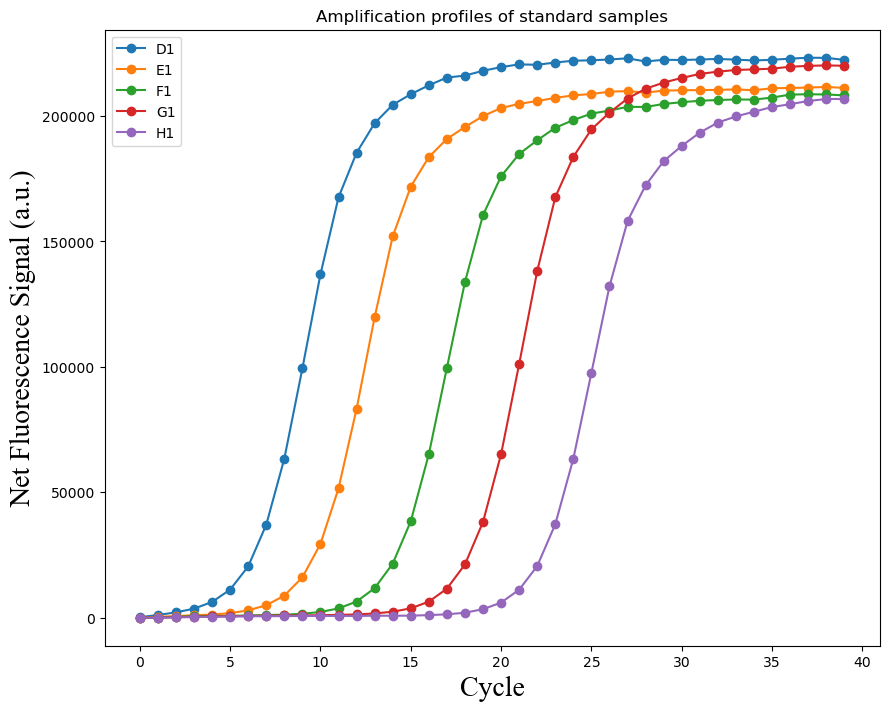

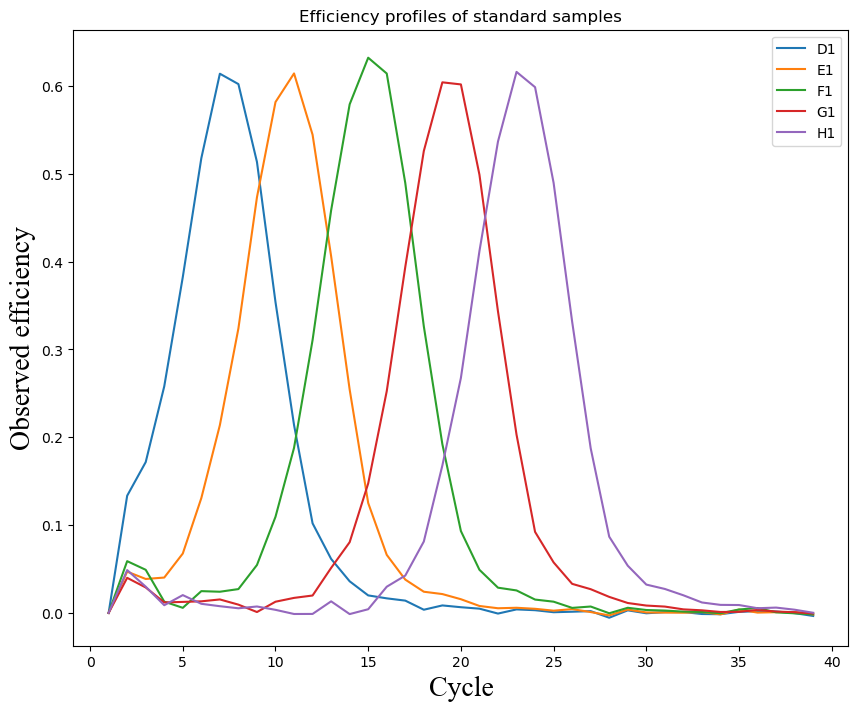

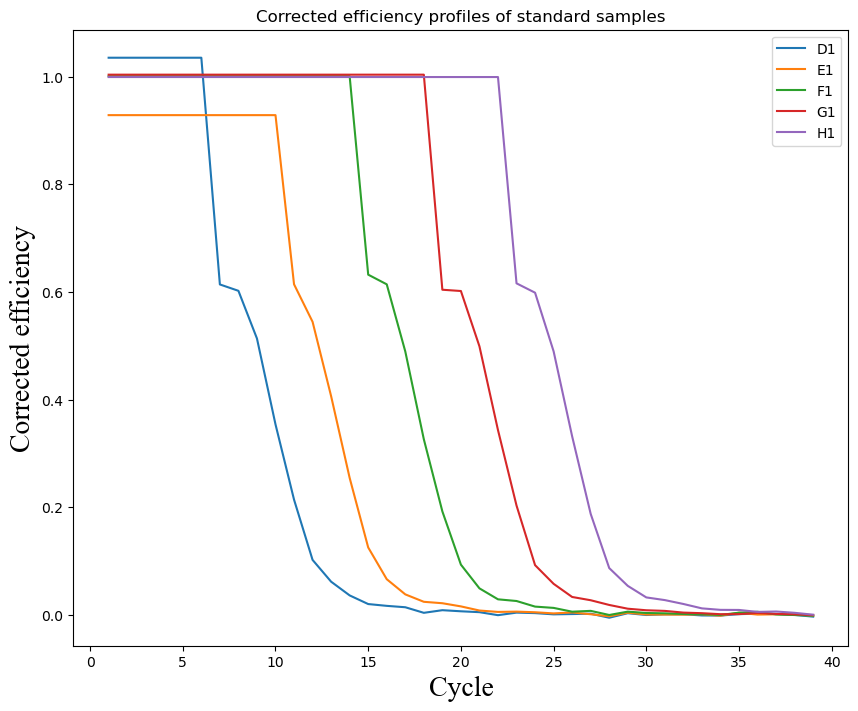

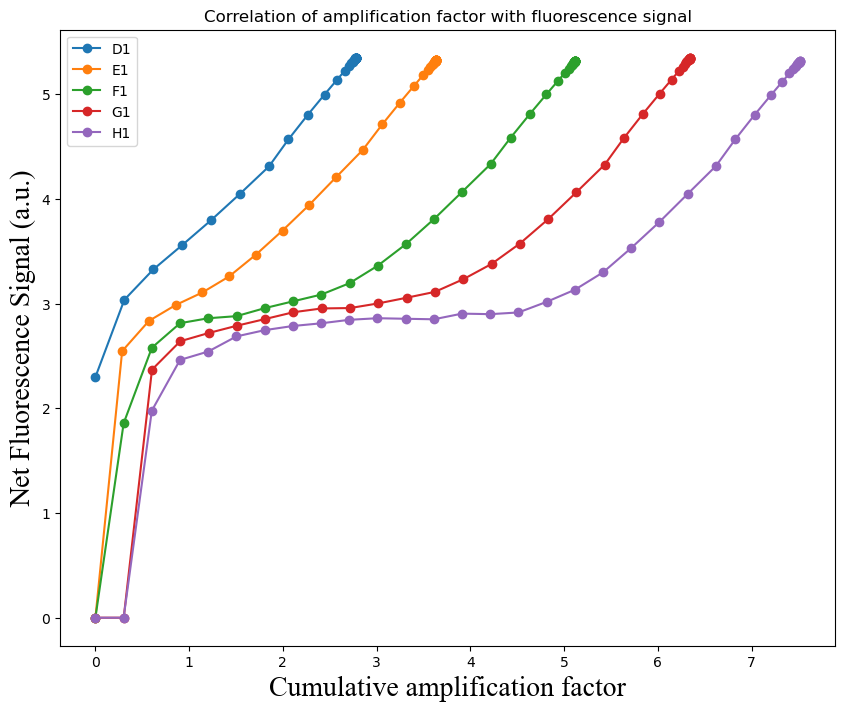

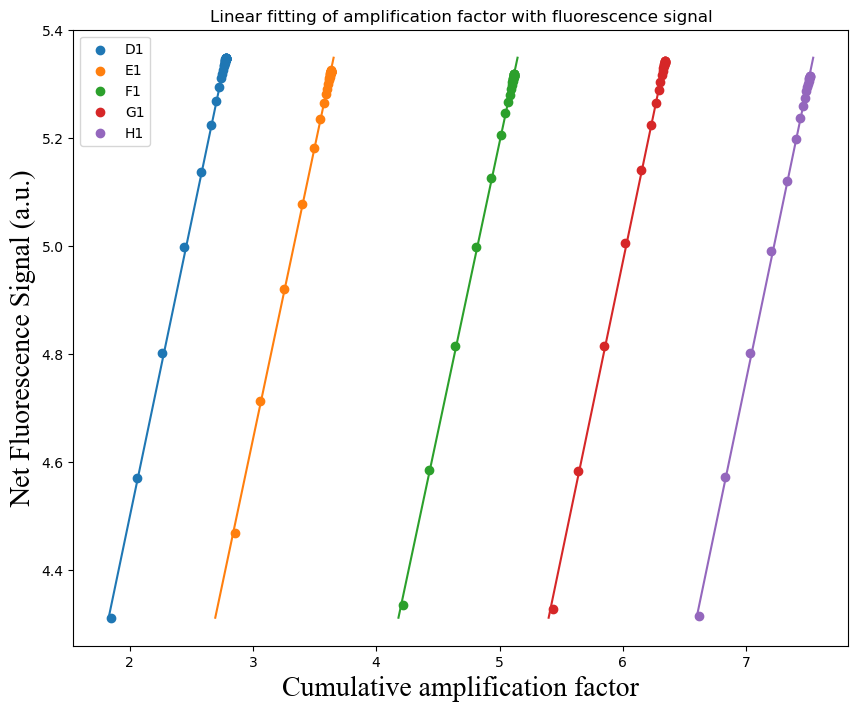

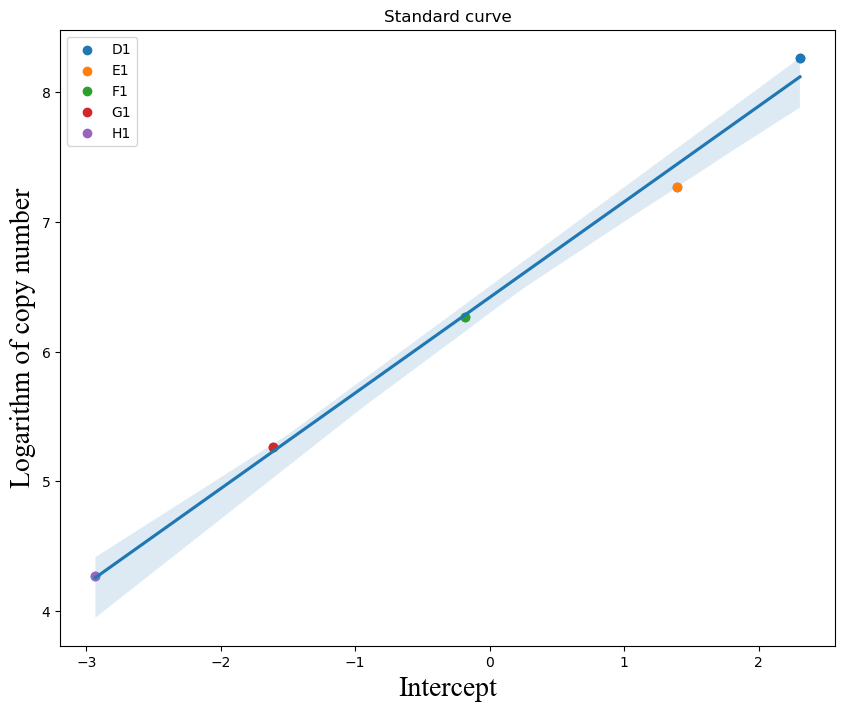

slope (95% confidence interval): 0.737383 +/- 0.101608
intercept (95% confidence interval): 6.418128 +/- 0.195437
R-squared: 0.994407
statistically significance: 0.00017781298648972485


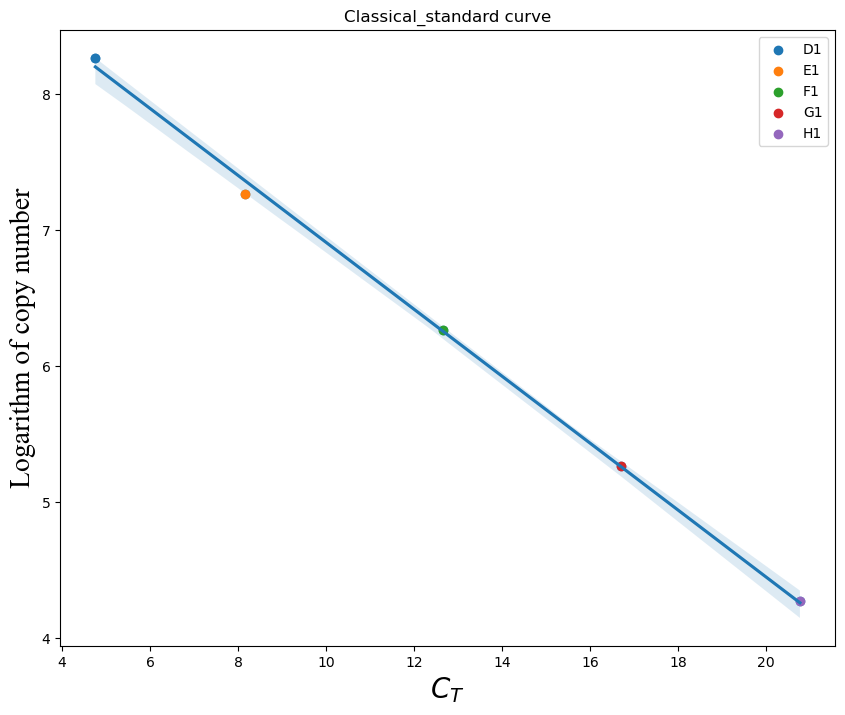

slope (95% confidence interval): -0.246206 +/- 0.016666
intercept (95% confidence interval): 9.372026 +/- 0.230918
R-squared: 0.998645
statistically significance: 2.1185730186707906e-05


In [8]:
qpcr.plot_standard_sample_amplification_profile()
qpcr.plot_standard_sample_efficiency()
qpcr.plot_standard_sample_corrected_efficiencies()
qpcr.plot_standard_sample_amp_caf()
qpcr.plot_standard_curve()
qpcr.plot_classical_standard_curve(10000)

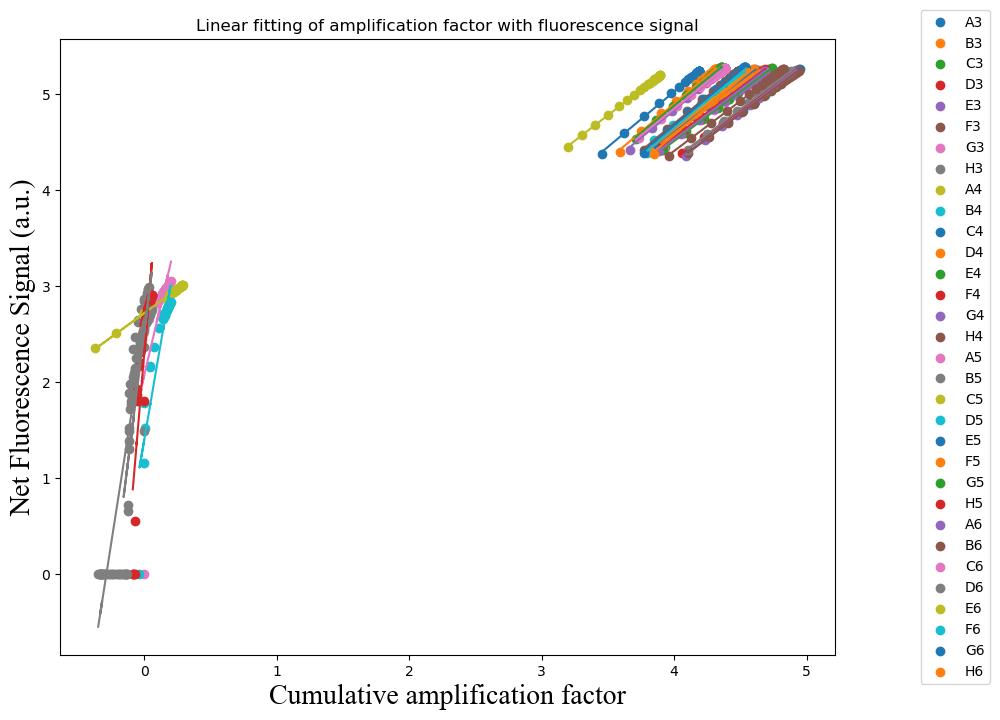

# 0: CNV for well A3 is 1.464169695104485
# 1: CNV for well B3 is 2.7027504341815827
# 2: CNV for well C3 is 2.2294401012880485
# 3: CNV for well D3 is 1.7432461948986513
# 4: CNV for well E3 is 0.7156432055003115
# 5: CNV for well F3 is 0.8703206426621147
# 6: CNV for well G3 is 1.1231637301491137
# 7: CNV for well H3 is 0.8605039943964489
# 8: CNV for well A4 is 2.0927271038836386
# 9: CNV for well B4 is 2.273613912671278
# 10: CNV for well C4 is 1.8579211770852755
# 11: CNV for well D4 is 1.687232605662323
# 12: CNV for well E4 is 1.878033934857143
# 13: CNV for well F4 is 2.1065629922264324
# 14: CNV for well G4 is 1.8303114460327514
# 15: CNV for well H4 is 1.4897883088398676
# 16: CNV for well A5 is 36.724129522542434
# 17: CNV for well B5 is 79.7159903077841
# 18: CNV for well C5 is 110.56347903921848
# 19: CNV for well D5 is 11.681586976293678
# 20: CNV for well E5 is 1.3490261702594115
# 21: CNV for well F5 is 0.9561921183830123
# 22: CNV for well G5 is 1.243399905785238
# 23:

In [9]:
ncnv2 = qpcr.calculate_CNV()

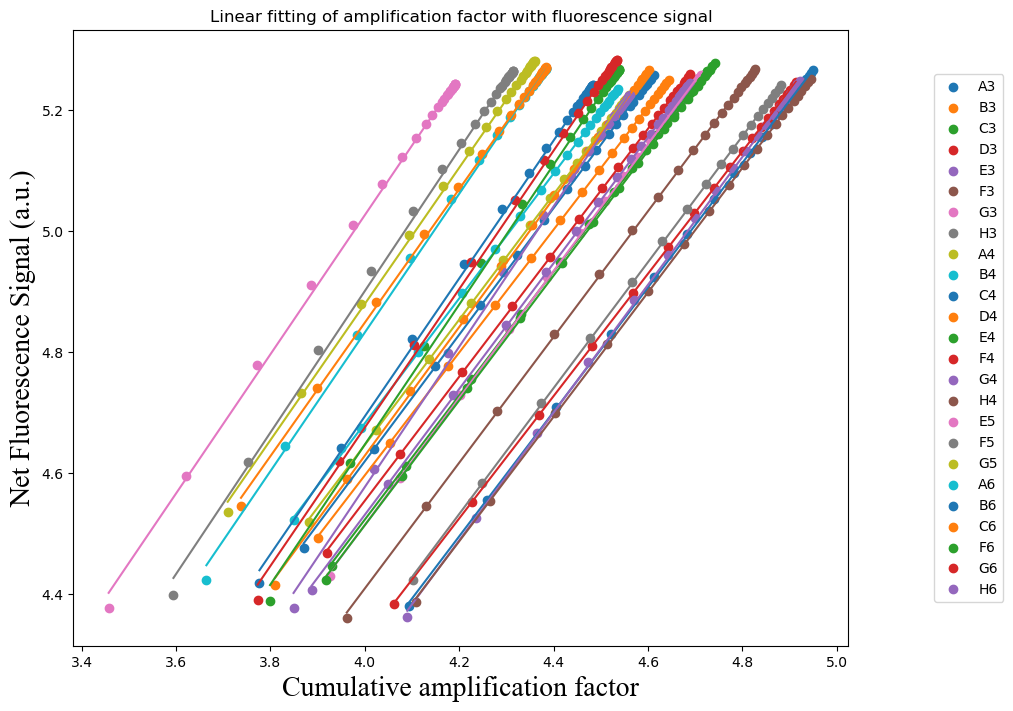

# 0: CNV for well A3 is 1.464169695104485
# 1: CNV for well B3 is 2.7027504341815827
# 2: CNV for well C3 is 2.2294401012880485
# 3: CNV for well D3 is 1.7432461948986513
# 4: CNV for well E3 is 0.7156432055003115
# 5: CNV for well F3 is 0.8703206426621147
# 6: CNV for well G3 is 1.1231637301491137
# 7: CNV for well H3 is 0.8605039943964489
# 8: CNV for well A4 is 2.0927271038836386
# 9: CNV for well B4 is 2.273613912671278
# 10: CNV for well C4 is 1.8579211770852755
# 11: CNV for well D4 is 1.687232605662323
# 12: CNV for well E4 is 1.878033934857143
# 13: CNV for well F4 is 2.1065629922264324
# 14: CNV for well G4 is 1.8303114460327514
# 15: CNV for well H4 is 1.4897883088398676
# 20: CNV for well E5 is 1.3490261702594115
# 21: CNV for well F5 is 0.9561921183830123
# 22: CNV for well G5 is 1.243399905785238
# 24: CNV for well A6 is 1.3528170423831685
# 25: CNV for well B6 is 1.118132801999696
# 26: CNV for well C6 is 1.8566664614206818
# 29: CNV for well F6 is 1.0067013480814089
# 30

In [10]:
ncnv2 = qpcr.calculate_CNV(exclude=["A5", "B5", "C5", "D5", "H5", "D6", "E6"])

In [11]:
ccnv2 = qpcr.calculate_CNV_classical(10000, exclude=["A5", "B5", "C5", "D5", "H5", "D6"])

# 0: CNV for well A3 is 0.05942820453312859
# 1: CNV for well B3 is 0.05153087505004337
# 2: CNV for well C3 is 0.0732867068318574
# 3: CNV for well D3 is 0.03534907773062718
# 4: CNV for well E3 is 0.011800665295681264
# 5: CNV for well F3 is 0.02125140916630285
# 6: CNV for well G3 is 0.02557779441940277
# 7: CNV for well H3 is 0.014455996651343908
# 8: CNV for well A4 is 0.0452662368922032
# 9: CNV for well B4 is 0.07630735731806018
# 10: CNV for well C4 is 0.06719470103385633
# 11: CNV for well D4 is 0.09423289814884163
# 12: CNV for well E4 is 0.06169027711515591
# 13: CNV for well F4 is 0.0701024124005144
# 14: CNV for well G4 is 0.09818587223741573
# 15: CNV for well H4 is 0.08787038568243412
# 20: CNV for well E5 is 0.5247905089075999
# 21: CNV for well F5 is 0.5326707265023941
# 22: CNV for well G5 is 0.42912221534453554
# 24: CNV for well A6 is 0.7609985889121683
# 25: CNV for well B6 is 0.73246706386169
# 26: CNV for well C6 is 0.5866973212618571
# 28: CNV for well E6 is 0.1

In [12]:
guanidine_ncnv = np.hstack((ncnv1[0:15], ncnv2[0:15]))
urea_ncnv = np.hstack((ncnv1[15:], ncnv2[15:]))
guanidine_ccnv = np.hstack((ccnv1[0:15], ccnv2[0:15]))
urea_ccnv = np.hstack((ccnv1[15:], ccnv2[15:]))
print("Assumption-free method: ")
print(f"mean copy number of ACT1 with guanidine: {guanidine_ncnv.mean()}, variance: {guanidine_ncnv.var()}")
print(f"mean copy number of ACT1 with urea: {urea_ncnv.mean()}, variance: {urea_ncnv.var()}")
print("Threshold method: ")
print(f"mean copy number of ACT1 with guanidine: {guanidine_ccnv.mean()}, variance: {guanidine_ccnv.var()}")
print(f"mean copy number of ACT1 with urea: {urea_ccnv.mean()}, variance: {urea_ccnv.var()}")

Assumption-free method: 
mean copy number of ACT1 with guanidine: 1.7054133671744904, variance: 0.2031699451337984
mean copy number of ACT1 with urea: 1.1223781626922062, variance: 0.057658777433093604
Threshold method: 
mean copy number of ACT1 with guanidine: 0.1625581643412549, variance: 0.012846511330140234
mean copy number of ACT1 with urea: 0.5437586542977331, variance: 0.026233915212323596


Text(0.5, 1.0, 'Histogram for QPCR copy number analysis with guanidine')

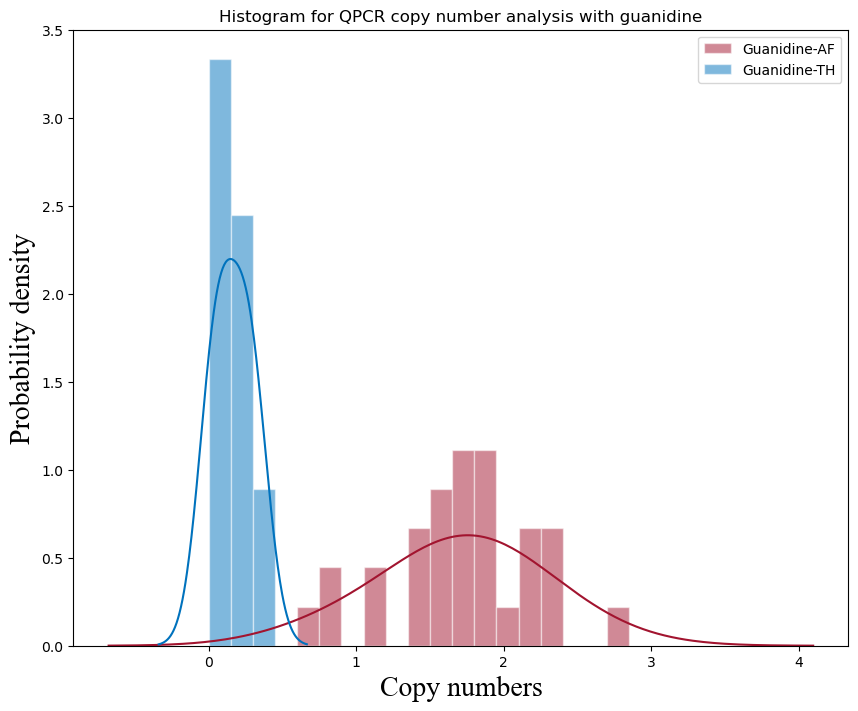

In [13]:
plt.figure(figsize=(10,8))
fontdict = {'family': 'Times New Roman', 'size': 20}
b = plt.hist(guanidine_ncnv, bins=20, range=(0,3), density=True,
             edgecolor='w', color='#A2142F', alpha=0.5, label="Guanidine-AF")
sns.kdeplot(guanidine_ncnv, bw_adjust=2, color='#A2142F')
d = plt.hist(guanidine_ccnv, bins=10, range=(0,1.5), density=True,
             edgecolor='w', color='#0072BD', alpha=0.5, label="Guanidine-TH")
sns.kdeplot(guanidine_ccnv, bw_adjust=2, color='#0072BD')
plt.xlabel("Copy numbers", fontdict=fontdict)
plt.ylabel("Probability density", fontdict=fontdict)
plt.legend()
plt.savefig("guanidine_copy_number_dist_compare.tif", dpi=300)
plt.title("Histogram for QPCR copy number analysis with guanidine")

Text(0.5, 1.0, 'Histogram for QPCR copy number analysis with urea')

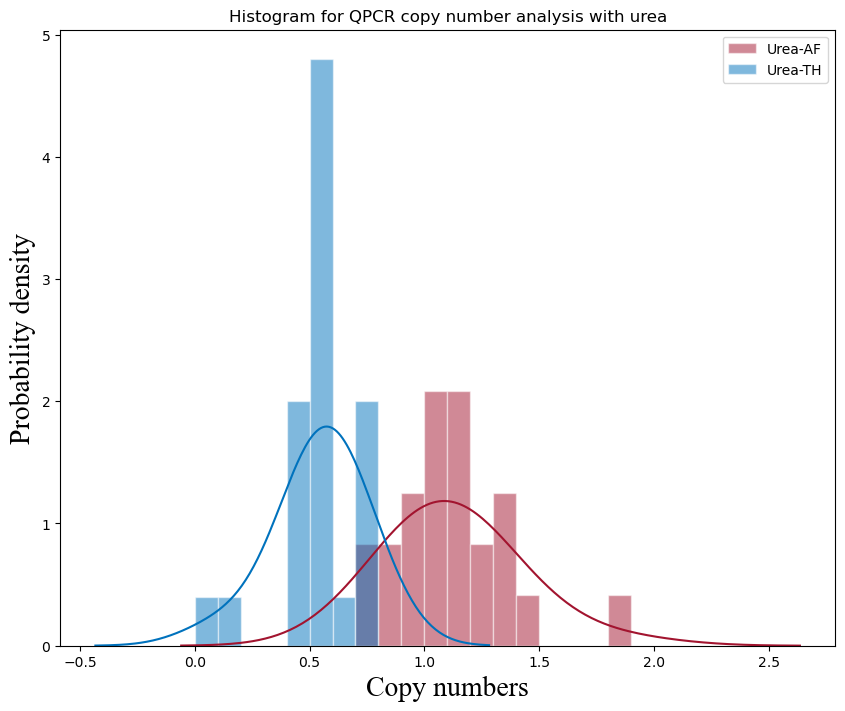

In [14]:
plt.figure(figsize=(10,8))
fontdict = {'family': 'Times New Roman', 'size': 20}
b = plt.hist(urea_ncnv, bins=20, range=(0,2), density=True,
             edgecolor='w', color='#A2142F', alpha=0.5, label="Urea-AF")
sns.kdeplot(urea_ncnv, bw_adjust=2, color='#A2142F')
d = plt.hist(urea_ccnv, bins=20, range=(0,2), density=True,
             edgecolor='w', color='#0072BD', alpha=0.5, label="Urea-TH")
sns.kdeplot(urea_ccnv, bw_adjust=2, color='#0072BD')
plt.xlabel("Copy numbers", fontdict=fontdict)
plt.ylabel("Probability density", fontdict=fontdict)
plt.legend()
plt.savefig("urea_copy_number_dist_compare.tif", dpi=300)
plt.title("Histogram for QPCR copy number analysis with urea")